# Building a car classifier

Continuing as we were...

The plan going in:

- Try some ways to deal with our class imbalance
- Try transfer learning by fine-tuning squeezenet or VGG16
- See how much we can gain via data augmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# system
import os
import glob
import itertools as it
import operator
from collections import defaultdict
from StringIO import StringIO

# other libraries
import cPickle as pickle
import numpy as np 
import pandas as pd
import scipy.io  # for loading .mat files
import scipy.misc # for imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import requests

In [150]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, GlobalAveragePooling2D
from keras.utils import np_utils

# https://github.com/fchollet/keras/issues/4499
from keras.layers.core import K
from keras.callbacks import TensorBoard

# for name scopes to make TensorBoard look prettier (doesn't work well yet)
import tensorflow as tf 

In [4]:
# my code
from display import (visualize_keras_model, plot_training_curves,
                     plot_confusion_matrix)
from helpers import combine_histories

In [5]:
%matplotlib inline
sns.set_style("white")
p = sns.color_palette()

# repeatability:
np.random.seed(42)

In [6]:
data_root = os.path.expanduser("~/data/cars")

# Load saved metadata

(the images are too big when stored raw -- faster to just reload from jpg)

In [7]:
from collections import namedtuple
Example = namedtuple('Example',
                     ['rel_path', 'x1', 'y1', 'x2','y2','cls','test'])

In [18]:
# Load data we saved in 10-cars.ipynb
with open('class_details.pkl') as f:
    loaded = pickle.load(f)
    macro_classes = loaded['macro_classes']
    macro_class_map = loaded['macro_class_map']
    cls_tuples = loaded['cls_tuples']
    classes = loaded['classes']
    examples = loaded['examples']
    by_class = loaded['by_class']
    by_car_type = loaded['by_car_type']

macro_class_map

{u'Convertible': 0,
 u'Coupe': 1,
 u'Minivan': 2,
 u'Pickup': 3,
 u'SUV': 4,
 u'Sedan': 5,
 u'Van': 6,
 u'Wagon': 7}

In [9]:
resized_path = os.path.join(data_root,'resized_car_ims') 

In [10]:
def gray_to_rgb(im):
    """
    Noticed (due to array projection error in code below) that there is at least
    one grayscale image in the dataset.
    We'll use this to convert.
    """
    w, h = im.shape
    ret = np.empty((w,h,3), dtype=np.uint8)
    ret[:,:,0] = im
    ret[:,:,1] = im
    ret[:,:,2] = im
    return ret

In [11]:
def load_examples(by_class, cls, limit=None):
    """
    Load examples for a class. Ignores test/train distinction -- 
    we'll do our own train/validation/test split later.
    
    Args:
        by_class: our above dict -- class_id -> [Example()]
        cls: which class to load
        limit: if not None, only load this many images.
        
    Returns:
        list of (X,y) tuples, one for each image.
            X: 3x227x227 ndarray of type uint8
            Y: class_id (will be equal to cls)
    """
    res = []
    to_load = by_class[cls]
    if limit:
        to_load = to_load[:limit]

    for ex in to_load:
        # load the resized image!
        img_path = os.path.join(data_root, 
                        ex.rel_path.replace('car_ims', 'resized_car_ims'))
        img = mpimg.imread(img_path)
        # handle any grayscale images
        if len(img.shape) == 2:
            img = gray_to_rgb(img)
        res.append((img, cls))
    return res

In [12]:
def split_examples(xs, valid_frac, test_frac):
    """
    Randomly splits the xs array into train, valid, test, with specified 
    percentages. Rounds down.
    
    Returns:
        (train, valid, test)
    """
    assert valid_frac + test_frac < 1
    
    n = len(xs)
    valid = int(valid_frac * n)
    test = int(test_frac * n)
    train = n - valid - test
    
    # don't change passed-in list
    shuffled = xs[:]
    np.random.shuffle(shuffled)

    return (shuffled[:train], 
            shuffled[train:train + valid], 
            shuffled[train + valid:])

# quick test
split_examples(range(10), 0.2, 0.4)

([8, 1, 5, 0], [7, 2], [9, 4, 3, 6])

In [13]:
def normalize_to_gray(xs):
    ret = (xs / 255.0).mean(axis=3)
    return np.reshape(ret, (-1, 227*227))

In [14]:
# Look at training data -- there's so little we can look at all of it

def plot_data(xs, ys, predicts):
    """Plot the images in xs, with corresponding correct labels
    and predictions.
    
    Args:
        xs: RGB or grayscale images with float32 values in [0,1].
        ys: one-hot encoded labels
        predicts: probability vectors (same dim as ys, normalized e.g. via softmax)
    """
    
    # sort all 3 by ys
    xs, ys, ps = zip(*sorted(zip(xs, ys, predicts), 
                             key=lambda tpl: tpl[1][0]))
    n = len(xs)
    rows = (n+9)/10
    fig, plots = plt.subplots(rows,10, sharex='all', sharey='all',
                             figsize=(20,2*rows), squeeze=False)
    for i in range(n):
        # read the image
        ax = plots[i // 10, i % 10]
        ax.axis('off')
        img = xs[i].reshape(227,227,-1) 

        if img.shape[-1] == 1: # Grayscale
            # Get rid of the unneeded dimension
            img = img.squeeze()
            # flip grayscale:
            img = 1-img 
            
        ax.imshow(img)
        # dot with one-hot vector picks out right element
        pcorrect = np.dot(ps[i], ys[i]) 
        if pcorrect > 0.8:
            color = "blue"
        else:
            color = "red"
        ax.set_title("{}   p={:.2f}".format(int(ys[i][0]), pcorrect),
                     loc='center', fontsize=18, color=color)
    return fig

In [15]:
# normalize the data, this time leaving it in color
def normalize_for_cnn(xs):
    ret = (xs / 255.0)
    return ret

In [16]:
def image_from_url(url):
    response = requests.get(url)
    img = Image.open(StringIO(response.content))
    return img

In [19]:
# Load images
IMG_PER_CAR = None # 20 # None to use all
valid_frac = 0.2
test_frac = 0.2

train = []
valid = []
test = []
for car_type, model_tuples in by_car_type.items():
    macro_class_id = macro_class_map[car_type]
    
    for model_tpl in model_tuples:
        cls = model_tpl[0]
        examples = load_examples(by_class, cls, limit=IMG_PER_CAR)
        # replace class labels with the id of the macro class
        examples = [(X, macro_class_id) for (X,y) in examples]
        # split each class separately, so all have same fractions of 
        # train/valid/test
        (cls_train, cls_valid, cls_test) = split_examples(
            examples,
            valid_frac, test_frac)
        # and add them to the overall train/valid/test sets
        train.extend(cls_train)
        valid.extend(cls_valid)
        test.extend(cls_test)

# ...and shuffle to make training work better.
np.random.shuffle(train)
np.random.shuffle(valid)
np.random.shuffle(test)

In [20]:
# We have lists of (X,Y) tuples. Let's unzip into lists of Xs and Ys.
X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# and turn into np arrays of the right dimension.
def convert_X(xs):
    '''
    Take list of (w,h,3) images.
    Turn into an np array, change type to float32.
    '''
    return np.array(xs).astype('float32')
    
X_train = convert_X(X_train)
X_valid = convert_X(X_valid)
X_test = convert_X(X_test)

In [21]:
X_train.shape

(9867, 227, 227, 3)

In [22]:
def convert_Y(ys, macro_classes):
    '''
    Convert to np array, make one-hot.
    Already ensured they're sequential from zero.
    '''
    n_classes = len(macro_classes)
    return np_utils.to_categorical(ys, n_classes)

Y_train = convert_Y(Y_train, macro_classes)
Y_valid = convert_Y(Y_valid, macro_classes)
Y_test = convert_Y(Y_test, macro_classes)

In [23]:
Y_train.shape

(9867, 8)

In [24]:
# normalize the data, this time leaving it in color
X_train_norm = normalize_for_cnn(X_train)
X_valid_norm = normalize_for_cnn(X_valid)
X_test_norm = normalize_for_cnn(X_test)

In [25]:
# Let's use more or less the same model to start (num classes changes)
def cnn_model2(use_dropout=True):
    model = Sequential()
    nb_filters = 16
    pool_size = (2,2)
    filter_size = 3
    nb_classes = len(macro_classes)
    
    with tf.name_scope("conv1") as scope:
        model.add(Convolution2D(nb_filters, filter_size, 
                            input_shape=(227, 227, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        if use_dropout:
            model.add(Dropout(0.5))

    with tf.name_scope("conv2") as scope:
        model.add(Convolution2D(nb_filters, filter_size))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        if use_dropout:
            model.add(Dropout(0.5))

    with tf.name_scope("conv3") as scope:
        model.add(Convolution2D(nb_filters, filter_size))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        if use_dropout:
            model.add(Dropout(0.5))

    with tf.name_scope("dense1") as scope:
        model.add(Flatten())
        model.add(Dense(16))
        model.add(Activation('relu'))
        if use_dropout:
            model.add(Dropout(0.5))

    with tf.name_scope("softmax") as scope:
        model.add(Dense(nb_classes))
        model.add(Activation('softmax'))
    return model

# Uncomment if getting a "Invalid argument: You must feed a value
# for placeholder tensor ..." when rerunning training. 
# K.clear_session() # https://github.com/fchollet/keras/issues/4499
    

model3 = cnn_model2()
model3.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [26]:
# This model will train slowly, so let's checkpoint it periodically
from keras.callbacks import ModelCheckpoint

In [28]:
recompute = False

if recompute:
#     # Save info during computation so we can see what's happening
#     tbCallback = TensorBoard(
#         log_dir='./graph', histogram_freq=1, 
#         write_graph=False, write_images=False)

    checkpoint = ModelCheckpoint('macro_class_cnn_checkpoint.5',
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True, mode='max',
                                 save_weights_only=True)

    # Fit the model! Using a bigger batch size and fewer epochs
    # because we have ~10K training images now instead of 100.
    history = model3.fit(
        X_train_norm, Y_train,
        batch_size=64, nb_epoch=50, verbose=1,
        validation_data=(X_valid_norm, Y_valid),
        callbacks=[checkpoint]
    )
else:
    model3.load_weights('macro_class_cnn.5')

In [29]:
# model3.save('macro_class_cnn.h5')

Model is starting to overfit. Let's try to diagnose what's going on, then decide what to do.

Now that we have 8 different classes, we can see how often they get confused for each other by looking at the aptly named confusion matrix. I would expect lots of confusion between coupe and sedan, and van and minivan, and suv and wagon. 

In [30]:
# Get the predictions
predict_train = model3.predict(X_train_norm)
predict_valid = model3.predict(X_valid_norm)
predict_test = model3.predict(X_test_norm)

Confusion matrix, without normalization
[[ 24  95   0   1  49 232   0   0]
 [  7 233   0   6  35 265   0   0]
 [  0   7   0   2  36  52   0   0]
 [  0  10   0 117 109  61   0   0]
 [  3  13   0  26 363 182   0   0]
 [  6  51   0   8 103 636   0   0]
 [  2   2   0   5  50  54   0   0]
 [  1  44   0   6  56 207   0   0]]


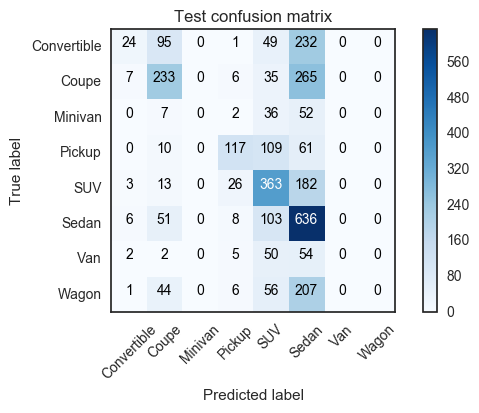

In [31]:
plot_confusion_matrix(Y_test, predict_test, macro_classes,
                      normalize=False,
                      title="Test confusion matrix");

Confusion matrix, without normalization
[[  56  283    0    9  151  757    0    0]
 [  14  723    0   14  138  820    0    0]
 [   0   12    0    3   66  223    0    0]
 [   0   23    0  333  377  187    0    0]
 [   0   40    0   76 1198  520    0    0]
 [   5  166    0   18  333 1992    0    0]
 [   0   20    0   18  149  165    0    0]
 [   3  126    0   16  151  682    0    0]]


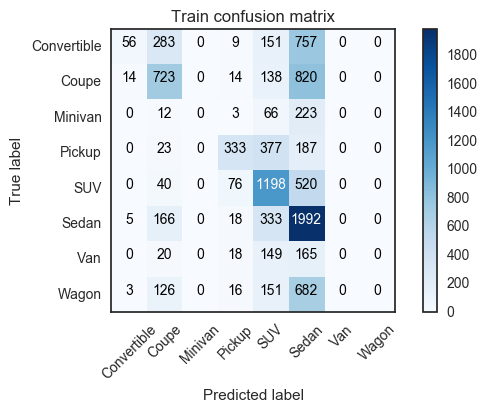

In [32]:
plot_confusion_matrix(Y_train, predict_train, macro_classes,
                      title="Train confusion matrix");

Normalized confusion matrix


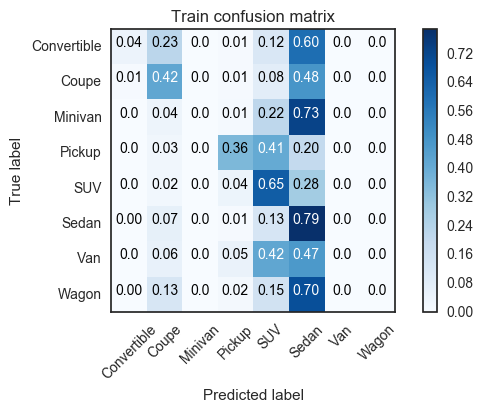

In [39]:
# Normalized to see per-class behavior better
plot_confusion_matrix(Y_train, predict_train, macro_classes,                      
                      title="Train confusion matrix", normalize=True);

Well, it seems that most car types are classified as sedan. Not too surprising, especially given that sedans are overrepresented. It's starting to learn that SUVs and pickups are different from sedans, and occasionally manages to distinguish coupes from sedans. 

So far, it doesn't use minivan, van, or wagon labels at all.

Things to check / do:
- Is it correctly getting coupe images from the side, incorrectly from the front or back?
- Look at class probabilities for some images, not just the maximal one
- Count how many training images we have for each class. May want to oversample the low prob classes.
- Try fine-tuning an off-the-shelf model.

<Container object of 8 artists>

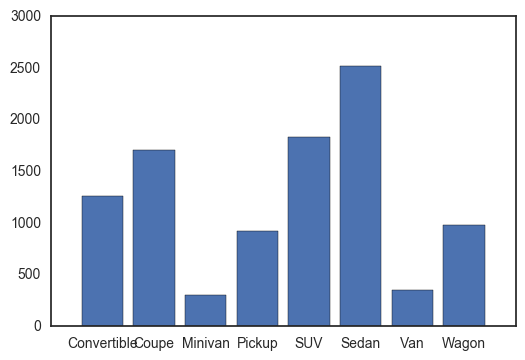

In [43]:
# What's our class balance
xs, counts = np.unique(np.argmax(Y_train, axis=1),return_counts=True)
plt.bar(xs, counts, tick_label=macro_classes, align='center')

Let's look at coupe mistakes on the train set

In [44]:
predict_train_labels = np.argmax(predict_train, axis=1)
correct_labels = np.argmax(Y_train, axis=1)

In [62]:
correct_train = np.where(predict_train_labels==correct_labels)[0]
wrong_train = np.where(predict_train_labels!=correct_labels)[0]
percent = 100 * len(correct_train)/float(len(correct_labels))
print("Training: {:.2f}% correct".format(percent))

Training: 43.60% correct


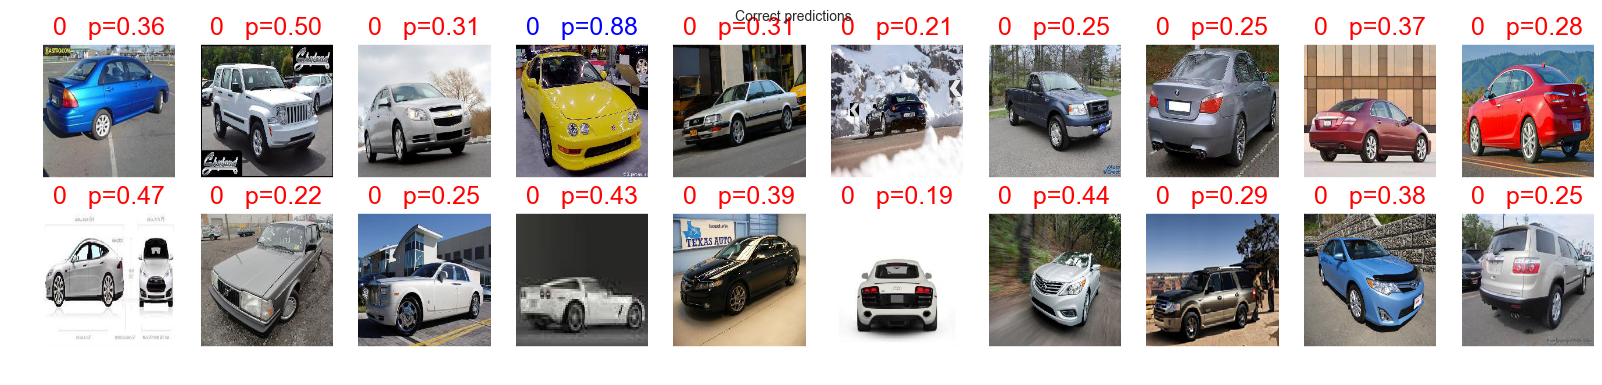

In [64]:
n_to_view = 20
subset = np.random.choice(correct_train, n_to_view, replace=False)
fig = plot_data(X_train_norm[subset], Y_train[subset], predict_train[subset]);
fig.suptitle("Correct predictions")

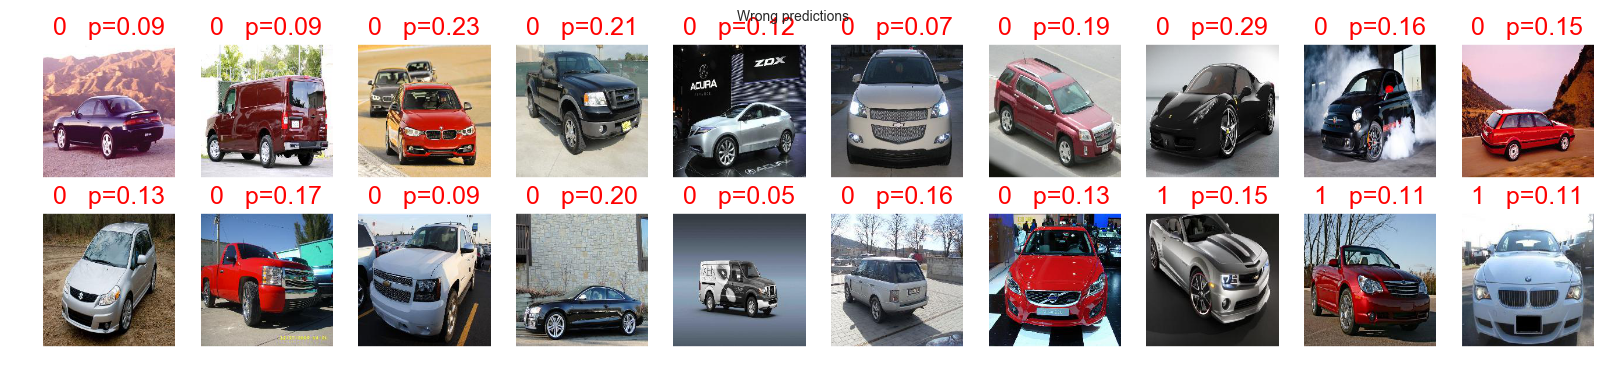

In [65]:
n_to_view = 20
subset = np.random.choice(wrong_train, n_to_view, replace=False)
fig = plot_data(X_train_norm[subset], Y_train[subset], predict_train[subset]);
fig.suptitle("Wrong predictions")

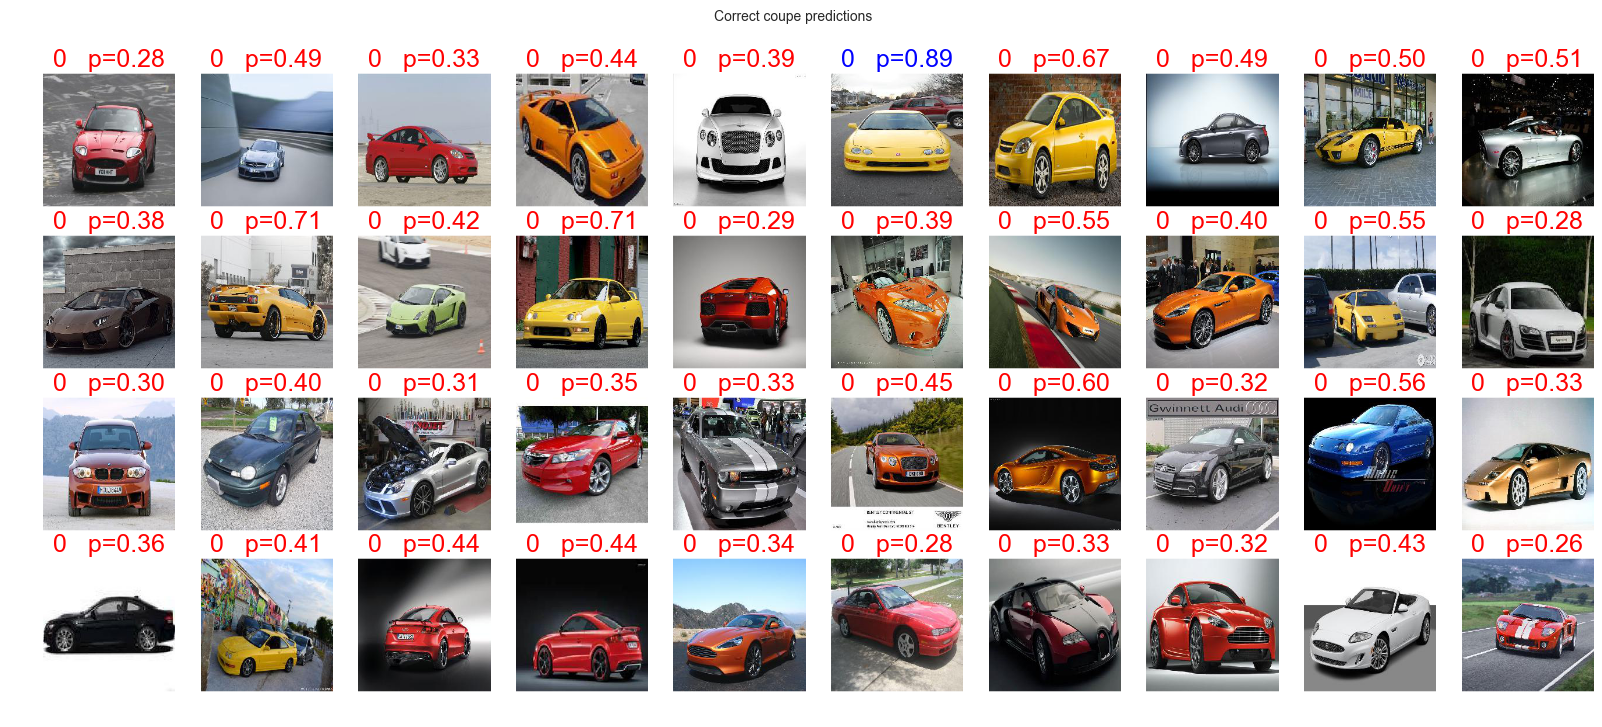

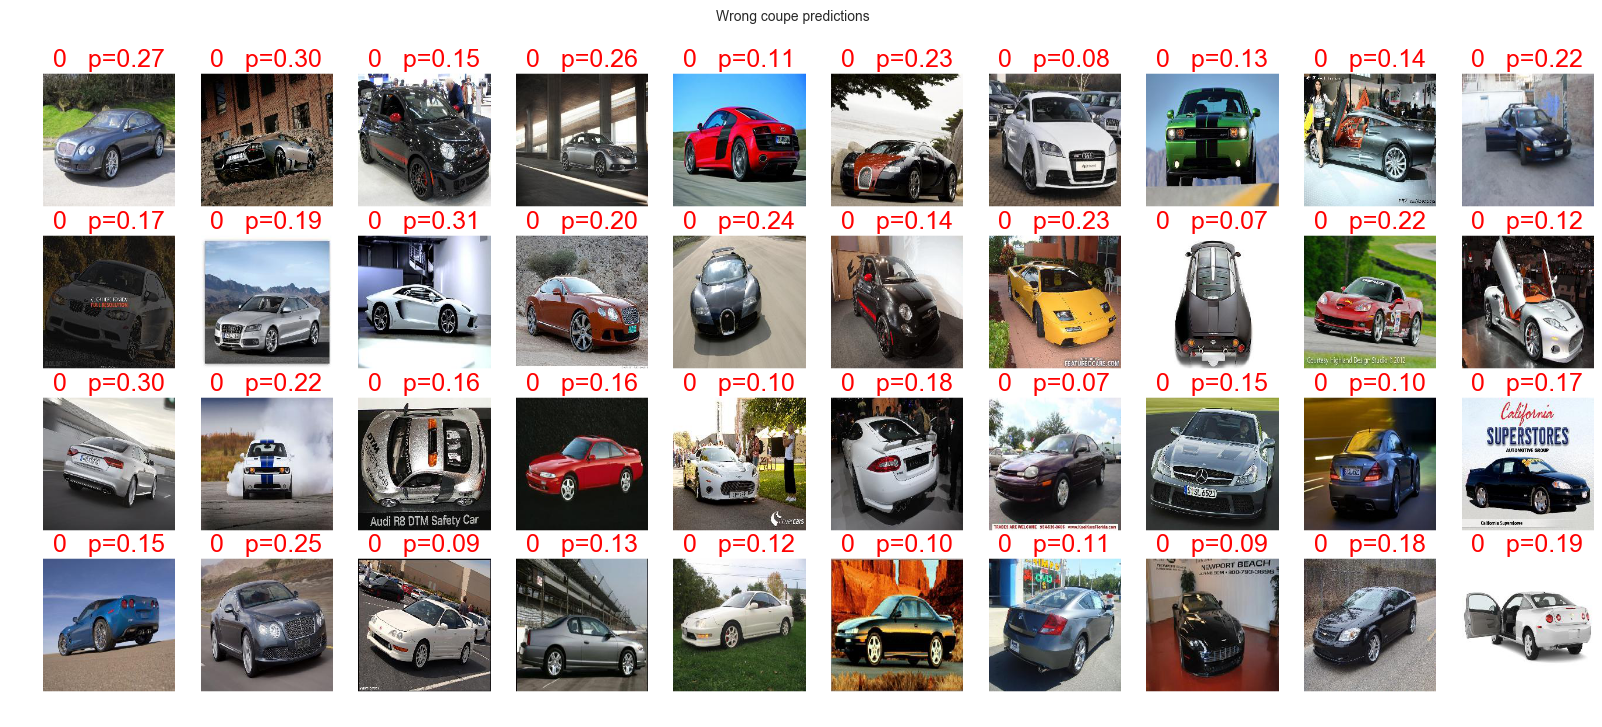

In [71]:
correct_coupe = np.where((predict_train_labels==correct_labels) & (correct_labels==macro_class_map['Coupe']))[0]
wrong_coupe = np.where((predict_train_labels!=correct_labels) & (correct_labels==macro_class_map['Coupe']))[0]

n_to_view = 40
subset = np.random.choice(correct_coupe, n_to_view, replace=False)
fig = plot_data(X_train_norm[subset], Y_train[subset], predict_train[subset]);
fig.suptitle("Correct coupe predictions")

subset = np.random.choice(wrong_coupe, n_to_view, replace=False)
fig = plot_data(X_train_norm[subset], Y_train[subset], predict_train[subset]);
fig.suptitle("Wrong coupe predictions")

Should make some functions to make this kind of analysis easier...

I don't see a clear pattern--side and front and back views in both sets of labels. One option is to keep training our own network... instead, lets try transfer learning using squeezenet. 

Let's try to use a model that's been trained on the imagenet dataset (1 million images!)

https://github.com/rcmalli/keras-squeezenet

In [72]:
!pip install keras_squeezenet

  Running setup.py bdist_wheel for keras-squeezenet ... - done
  Stored in directory: /Users/shnayder/Library/Caches/pip/wheels/94/37/36/900c81337d77ce40e20250809226b3690651f50be94d51f186
Successfully built keras-squeezenet


In [73]:
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

In [ ]:
model = SqueezeNet()

In [85]:
X_train[0]

array([[[-883.11999512, -820.01098633, -700.4510498 ],
        [-883.11999512, -820.01098633, -700.4510498 ],
        [-883.11999512, -820.01098633, -700.4510498 ],
        ..., 
        [-918.11999512, -855.01098633, -735.4510498 ],
        [-918.11999512, -855.01098633, -735.4510498 ],
        [-918.11999512, -855.01098633, -735.4510498 ]],

       [[-882.11999512, -819.01098633, -699.4510498 ],
        [-882.11999512, -819.01098633, -699.4510498 ],
        [-882.11999512, -819.01098633, -699.4510498 ],
        ..., 
        [-916.11999512, -853.01098633, -733.4510498 ],
        [-916.11999512, -853.01098633, -733.4510498 ],
        [-916.11999512, -853.01098633, -733.4510498 ]],

       [[-881.11999512, -818.01098633, -698.4510498 ],
        [-881.11999512, -818.01098633, -698.4510498 ],
        [-881.11999512, -818.01098633, -698.4510498 ],
        ..., 
        [-913.11999512, -850.01098633, -730.4510498 ],
        [-913.11999512, -850.01098633, -730.4510498 ],
        [-913.11999

('Predicted:', [[(u'n04285008', u'sports_car', 0.5435679), (u'n02974003', u'car_wheel', 0.41837999), (u'n03100240', u'convertible', 0.017516876), (u'n02814533', u'beach_wagon', 0.013616056), (u'n03459775', u'grille', 0.0029945327)]])


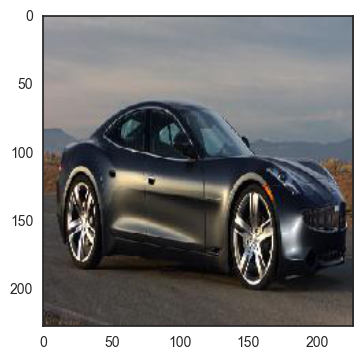

In [87]:
img = X_train[1]
plt.imshow(img/255.0)
x = img# image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# preprocess_input modifies its argument!
x = preprocess_input(x.copy())

preds = model.predict(x)

print('Predicted:', decode_predictions(preds))

# Adapting Squeezenet

Let's replace the output layer with a smaller classifier
Following some comments at https://github.com/fchollet/keras/issues/2371 and our code in 07-transfer.

In [89]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792                                         
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0                                            
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0                                            
___________________________________________________________________________________________

In [133]:
X_train[0] = X_train[0,:,:,::-1]

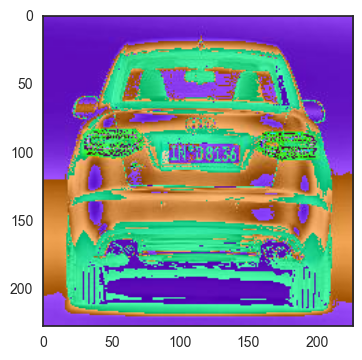

In [134]:
# screwed up X_train[0] earlier. Rather than rerun, just hack it manually.
plt.imshow(X_train[0])


In [140]:
# We want to pull out the activations before conv10...

from keras.models import Model

# Get input
new_input = model.input
# Find the layer to connect
hidden_layer = model.get_layer('drop9').output
# Build a new model
bottleneck_model = Model(new_input, hidden_layer)
bottleneck_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792                                         
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0                                            
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0                                            
___________________________________________________________________________________________

In [144]:
16000 * 13 * 13 * 512 * 4 / 2**20

5281

This will generate 5G of saved features! I guess I can save 20% by not pre-computing the test ones, but doesn't seem worth it. Instead, let's first train on a subset. We'll ignore the test set entirely, and see if we can get reasonable 
validation performance by using 2000 training images and 1000 validation.

In [146]:
train_subset = 2000
valid_subset = 1000

In [148]:
def save_bottlebeck_features(bottleneck_model, xs, name):
    # don't change the param!
    xs = preprocess_input(xs.copy())
    bottleneck_features = bottleneck_model.predict(xs)
    
    with open('cars_bottleneck_features_{}.npy'.format(name), 'w') as f:
        np.save(f, bottleneck_features)

def save_labels(ys, name):
    with open('cars_bottleneck_labels_{}.npy'.format(name), 'w') as f:
        np.save(f, ys)

        
if False: # change to recompute  
    save_bottlebeck_features(bottleneck_model, X_train[:train_subset], 'train_subset')
    save_bottlebeck_features(bottleneck_model, X_valid[:valid_subset], 'valid_subset')
    # save_bottlebeck_features(bottleneck_model, X_test, 'test')
    
    save_labels(Y_train[:train_subset], 'train_subset')
    save_labels(Y_valid[:valid_subset], 'valid_subset')

In [149]:
!ls -lh cars*

-rw-r--r--@ 1 shnayder  staff   660M Mar 21 22:30 cars_bottleneck_features_train_subset.npy
-rw-r--r--@ 1 shnayder  staff   330M Mar 21 22:31 cars_bottleneck_features_valid_subset.npy
-rw-r--r--@ 1 shnayder  staff   125K Mar 21 22:32 cars_bottleneck_labels_train_subset.npy
-rw-r--r--@ 1 shnayder  staff    63K Mar 21 22:32 cars_bottleneck_labels_valid_subset.npy


In [159]:
def load_features(name):
    with open('cars_bottleneck_features_{}.npy'.format(name), 'r') as f:
        return np.load(f)

def load_labels(name):
    with open('cars_bottleneck_labels_{}.npy'.format(name)) as f:
        return np.load(f)


top_model_weights_path = 'cars_bottleneck_fc_model.h5'    
    
# Now let's train the model -- we'll put the same squeezenet structure, just with fewer classes
def make_top_model():
    inputs = Input((13,13,512))
    x = Convolution2D(len(macro_classes), (1, 1), padding='valid', name='new_conv10')(inputs)
    x = Activation('relu', name='new_relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    model = Model(inputs, out, name='squeezed_top')
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

top_model = make_top_model()
print(top_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 13, 13, 512)       0         
_________________________________________________________________
new_conv10 (Conv2D)          (None, 13, 13, 8)         4104      
_________________________________________________________________
new_relu_conv10 (Activation) (None, 13, 13, 8)         0         
_________________________________________________________________
global_average_pooling2d_12  (None, 8)                 0         
_________________________________________________________________
loss (Activation)            (None, 8)                 0         
Total params: 4,104.0
Trainable params: 4,104.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [155]:
train_data = load_features('train_subset')
train_labels = load_labels('train_subset')

valid_data = load_features('valid_subset')
valid_labels = load_labels('valid_subset')

In [160]:
epochs = 50
batch_size = 128
history = top_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(valid_data, valid_labels))

top_model.save_weights(top_model_weights_path)

Train on 2000 samples, validate on 1000 samples
Epoch 1/50
2000/2000 [==============================] - 2s - loss: 0.6193 - acc: 0.8186 - val_loss: 0.5271 - val_acc: 0.8326
Epoch 2/50
2000/2000 [==============================] - 1s - loss: 0.4631 - acc: 0.8430 - val_loss: 0.4296 - val_acc: 0.8470
Epoch 3/50
2000/2000 [==============================] - 1s - loss: 0.3916 - acc: 0.8594 - val_loss: 0.3826 - val_acc: 0.8586
Epoch 4/50
2000/2000 [==============================] - 1s - loss: 0.3539 - acc: 0.8688 - val_loss: 0.3588 - val_acc: 0.8633
Epoch 5/50
2000/2000 [==============================] - 1s - loss: 0.3310 - acc: 0.8729 - val_loss: 0.3467 - val_acc: 0.8650
Epoch 6/50
2000/2000 [==============================] - 1s - loss: 0.3140 - acc: 0.8790 - val_loss: 0.3346 - val_acc: 0.8677
Epoch 7/50
2000/2000 [==============================] - 1s - loss: 0.3008 - acc: 0.8834 - val_loss: 0.3245 - val_acc: 0.8720
Epoch 8/50
2000/2000 [==============================] - 1s - loss: 0.2859 - a

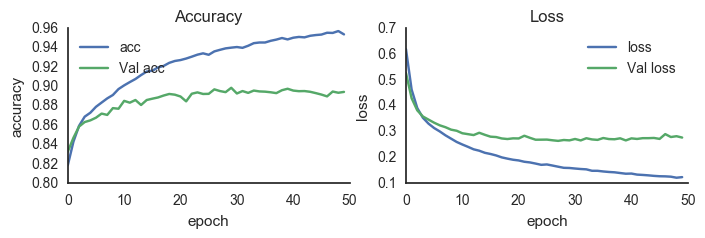

In [162]:
plot_training_curves(history.history);

Almost 90% validation accuracy! Clearly we should have stopped earlier. Let's take a quick look at the confusion matrix.

In [163]:
predict_train = top_model.predict(train_data)

Confusion matrix, without normalization
Normalized confusion matrix


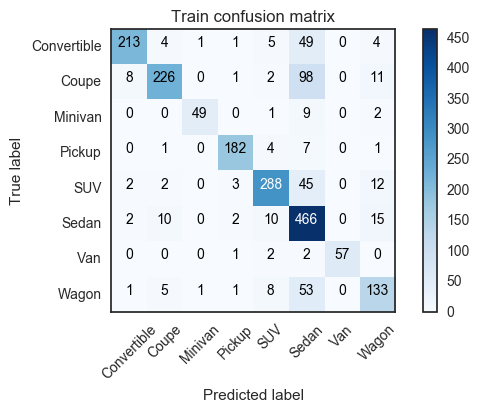

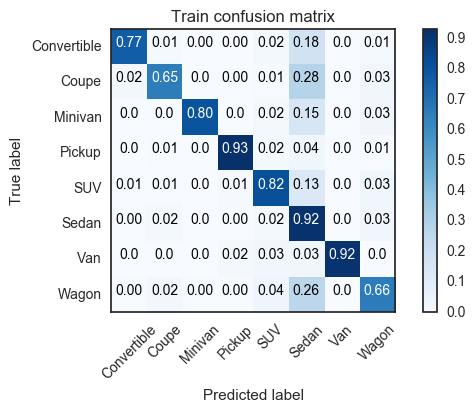

In [166]:
plot_confusion_matrix(train_labels, predict_train, macro_classes,                      
                      title="Train confusion matrix");
plt.figure()
plot_confusion_matrix(train_labels, predict_train, macro_classes,                      
                      title="Train confusion matrix",
                     normalize=True);

So we're making relatively few mistakes with pickups and vans and sedans, somewhat more with SUVs, and confusing wagons, convertibles, and coupes for sedans. Makes sense. Perhaps we should combine all those classes together anyway.

We could fine-tune the network and do data augmentation too. For now, let's just train on the rest of our training data.

In [167]:
def compute_bottleneck_features(xs):
    xs = preprocess_input(xs.copy())
    return bottleneck_model.predict(xs)

rest_train_data = compute_bottleneck_features(X_train[train_subset:])
rest_train_labels = Y_train[train_subset:]

In [168]:
epochs = 50
batch_size = 128
history2 = top_model.fit(rest_train_data, rest_train_labels,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(valid_data, valid_labels))

Train on 7867 samples, validate on 1000 samples
Epoch 1/50
7867/7867 [==============================] - 6s - loss: 0.2646 - acc: 0.8978 - val_loss: 0.2447 - val_acc: 0.9044
Epoch 2/50
7867/7867 [==============================] - 5s - loss: 0.2384 - acc: 0.9052 - val_loss: 0.2610 - val_acc: 0.8935
Epoch 3/50
7867/7867 [==============================] - 5s - loss: 0.2276 - acc: 0.9089 - val_loss: 0.2278 - val_acc: 0.9056
Epoch 4/50
7867/7867 [==============================] - 5s - loss: 0.2182 - acc: 0.9127 - val_loss: 0.2317 - val_acc: 0.9039
Epoch 5/50
7867/7867 [==============================] - 5s - loss: 0.2114 - acc: 0.9147 - val_loss: 0.2274 - val_acc: 0.9067
Epoch 6/50
7867/7867 [==============================] - 5s - loss: 0.2061 - acc: 0.9168 - val_loss: 0.2228 - val_acc: 0.9067
Epoch 7/50
7867/7867 [==============================] - 5s - loss: 0.2004 - acc: 0.9180 - val_loss: 0.2291 - val_acc: 0.9046
Epoch 8/50
7867/7867 [==============================] - 5s - loss: 0.1959 - a

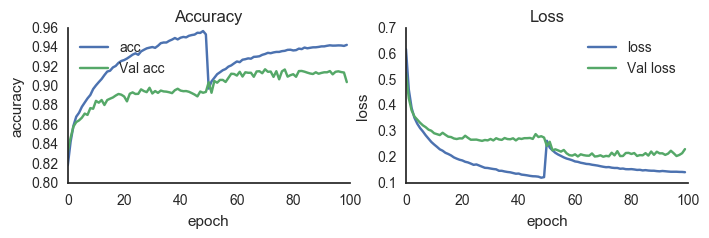

In [169]:
from helpers import combine_histories
plot_training_curves(combine_histories(history.history, history2.history));

Ok, that got us about 2 more percent. Let's save these weights.

In [170]:
top_model.save_weights(top_model_weights_path)

# Next steps...

We'll stop for now, but here are some things to do if continuing.

* Continue to improve the classifier by using data augmentation
* Fine-tune several layers of squeezenet
* Combine classes as discussed above, and make a handy function to
take an image and run it through the combined network to give a classification...